# Testing compatability of `ddls` with `rllib`

In [7]:
%load_ext autoreload
from ddls.environments.job_placing.job_placing_all_nodes_environment import JobPlacingAllNodesEnvironment
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform
from ddls.dgl_tests.rllib_model_test import GNNPolicy
from ddls.plotting.plotting import plot_line

import ray
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
ray.shutdown()
ray.init()

from ray.rllib.models import ModelCatalog
from ray.rllib.agents import ppo


from omegaconf import OmegaConf
from IPython.display import display
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Register the custom environment with `ray`

In [8]:
register_env('job_placing_all_nodes_environment', lambda env_config: JobPlacingAllNodesEnvironment(**env_config))

### Register the custom model with `rllib`

In [9]:
ModelCatalog.register_custom_model('my_model', GNNPolicy)

### Load `rllib` config

In [10]:
# # load config
# config = OmegaConf.load('configs/ddls_job_placing_rllib.yaml')
# print(OmegaConf.to_yaml(config))

# # convert config to dict so that is comparible with rllib
# config = OmegaConf.to_container(config, resolve=False)
# print(config)

In [20]:
%autoreload
node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}


env_config = {'node_config': node_config,
              'topology_config': topology_config,
              'jobs_config': jobs_config,
              'reward_function': 'mean_job_completion_time'}


rllib_config = {
    
    'seed': 0,
    
    'env': 'job_placing_all_nodes_environment',
    
    'env_config': env_config,
    
    'batch_mode': 'complete_episodes',
    'train_batch_size': 128,
    'sgd_minibatch_size': 128
        
    
}

# print(OmegaConf.to_yaml(rllib_config))
print(rllib_config)

{'seed': 0, 'env': 'job_placing_all_nodes_environment', 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}, 'topology_config': {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid', 'job_interarrival_time_dist': <ddls.distributions.uniform.Uniform object at 0x7fd6d8729760>, 'max_files': 1, 'job_sampling_mode': 'remove'}, 'reward_function': 'mean_job_completion_time'}, 'batch_mode': 'complete_episodes', 'train_batch_size': 128, 'sgd_minibatch_size': 128}


### Initialise an `rllib` epoch loop

In [21]:
%autoreload

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(rllib_config)
print(f'Config:\n{ppo_config}')

# initialise rllib trainer
epoch_loop = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

2022-04-13 15:48:42,237	WARNING ppo.py:223 -- `train_batch_size` (128) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 64.


Config:
{'num_workers': 2, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 128, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_us

2022-04-13 15:48:53,014	INFO trainable.py:127 -- Trainable.setup took 10.780 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-13 15:48:53,016	WARNING util.py:55 -- Install gputil for GPU system monitoring.



Initialised trainer.


### Run `rllib` on the `ddls` environment

In [22]:
%autoreload

agent_name = 'PPO'
num_epochs = 50
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = epoch_loop.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
# display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 50 -------
agent_timesteps_total: 128
custom_metrics: {}
date: 2022-04-13_15-48-57
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.851022019014805
episode_reward_min: -4.313972618860607
episodes_this_iter: 128
episodes_total: 128
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 4.104190349578857
        entropy_coeff: 0.0
        kl: 0.0583382248878479
        model: {}
        policy_loss: -0.14000539481639862
        total_loss: 11.510553359985352
        vf_explained_var: -8.940696716308594e-08
        vf_loss: 11.638890266418457
  num_agent_steps_sampled: 128
  num_agent_steps_trained: 128
  num_steps_sampled: 128
  num_steps_trained: 128
  num_steps_trained_this_iter: 128
iterations_since_

agent_timesteps_total: 768
custom_metrics: {}
date: 2022-04-13_15-49-18
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.8076684288814464
episode_reward_min: -3.8731461513282555
episodes_this_iter: 128
episodes_total: 768
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 4.999999873689376e-05
        entropy: 3.364596366882324
        entropy_coeff: 0.0
        kl: 0.04775531589984894
        model: {}
        policy_loss: -0.1437722146511078
        total_loss: -0.1112782210111618
        vf_explained_var: -1.1920928955078125e-07
        vf_loss: 0.00025917263701558113
  num_agent_steps_sampled: 768
  num_agent_steps_trained: 768
  num_steps_sampled: 768
  num_steps_trained: 768
  num_steps_trained_this_iter: 128
iterations_since_restore: 6
node_ip: 128.4

agent_timesteps_total: 1408
custom_metrics: {}
date: 2022-04-13_15-49-39
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.8042035303520043
episode_reward_min: -4.015820634262068
episodes_this_iter: 128
episodes_total: 1408
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.37968748807907104
        cur_lr: 4.999999873689376e-05
        entropy: 3.0346057415008545
        entropy_coeff: 0.0
        kl: 0.010020620189607143
        model: {}
        policy_loss: -0.04050957038998604
        total_loss: -0.03629922494292259
        vf_explained_var: 0.0
        vf_loss: 0.0004056523321196437
  num_agent_steps_sampled: 1408
  num_agent_steps_trained: 1408
  num_steps_sampled: 1408
  num_steps_trained: 1408
  num_steps_trained_this_iter: 128
iterations_since_restore: 11
node_ip: 128.40.41.23
n

agent_timesteps_total: 2048
custom_metrics: {}
date: 2022-04-13_15-50-01
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.8013693258951395
episode_reward_min: -3.8040712488856605
episodes_this_iter: 128
episodes_total: 2048
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.569531261920929
        cur_lr: 4.999999873689376e-05
        entropy: 2.6979079246520996
        entropy_coeff: 0.0
        kl: 0.007321514189243317
        model: {}
        policy_loss: -0.03871023654937744
        total_loss: -0.03453998640179634
        vf_explained_var: 2.384185791015625e-07
        vf_loss: 4.16254380297687e-07
  num_agent_steps_sampled: 2048
  num_agent_steps_trained: 2048
  num_steps_sampled: 2048
  num_steps_trained: 2048
  num_steps_trained_this_iter: 128
iterations_since_restore: 16
node_ip

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/ray/rllib/utils/metrics/learner_info.py:64: RuntimeWarning: Mean of empty slice
  lambda *s: None if s[0] is None else np.nanmean(s, axis=0),


agent_timesteps_total: 2432
custom_metrics: {}
date: 2022-04-13_15-50-13
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 2432
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.2847656309604645
        cur_lr: 4.999999873689376e-05
        entropy: 2.642399549484253
        entropy_coeff: 0.0
        kl: 3.7949772377032787e-05
        model: {}
        policy_loss: 0.0
        total_loss: 1.0962879059661645e-05
        vf_explained_var: 'null'
        vf_loss: 1.5608722492288507e-07
  num_agent_steps_sampled: 2432
  num_agent_steps_trained: 2432
  num_steps_sampled: 2432
  num_steps_trained: 2432
  num_steps_trained_this_iter: 128
iterations_since_restore: 19
node_ip: 128.40.41.23
num_healthy_w

agent_timesteps_total: 3072
custom_metrics: {}
date: 2022-04-13_15-50-35
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.802248006343955
episode_reward_min: -3.918187661358925
episodes_this_iter: 128
episodes_total: 3072
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.03559570387005806
        cur_lr: 4.999999873689376e-05
        entropy: 2.513827323913574
        entropy_coeff: 0.0
        kl: 0.015691716223955154
        model: {}
        policy_loss: -0.028790365904569626
        total_loss: -0.02812272123992443
        vf_explained_var: 0.0
        vf_loss: 0.00010908160038525239
  num_agent_steps_sampled: 3072
  num_agent_steps_trained: 3072
  num_steps_sampled: 3072
  num_steps_trained: 3072
  num_steps_trained_this_iter: 128
iterations_since_restore: 24
node_ip: 128.40.41.23
n

agent_timesteps_total: 3712
custom_metrics: {}
date: 2022-04-13_15-50-56
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 3712
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.01779785193502903
        cur_lr: 4.999999873689376e-05
        entropy: 2.2345590591430664
        entropy_coeff: 0.0
        kl: 0.0018309004371985793
        model: {}
        policy_loss: 0.0
        total_loss: 3.263668259023689e-05
        vf_explained_var: 'null'
        vf_loss: 5.05844646170317e-08
  num_agent_steps_sampled: 3712
  num_agent_steps_trained: 3712
  num_steps_sampled: 3712
  num_steps_trained: 3712
  num_steps_trained_this_iter: 128
iterations_since_restore: 29
node_ip: 128.40.41.23
num_healthy_wor

agent_timesteps_total: 4352
custom_metrics: {}
date: 2022-04-13_15-51-17
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 4352
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.0005561828729696572
        cur_lr: 4.999999873689376e-05
        entropy: 2.2303757667541504
        entropy_coeff: 0.0
        kl: -1.8681408420206935e-08
        model: {}
        policy_loss: 0.0
        total_loss: -1.0219750393170024e-11
        vf_explained_var: 'null'
        vf_loss: 1.7053025658242404e-13
  num_agent_steps_sampled: 4352
  num_agent_steps_trained: 4352
  num_steps_sampled: 4352
  num_steps_trained: 4352
  num_steps_trained_this_iter: 128
iterations_since_restore: 34
node_ip: 128.40.41.23
num_hea

agent_timesteps_total: 4992
custom_metrics: {}
date: 2022-04-13_15-51-37
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 4992
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.7380714780301787e-05
        cur_lr: 4.999999873689376e-05
        entropy: 2.2303757667541504
        entropy_coeff: 0.0
        kl: -2.0151066593143696e-08
        model: {}
        policy_loss: 0.0
        total_loss: -3.502399379632509e-13
        vf_explained_var: 'null'
        vf_loss: 0.0
  num_agent_steps_sampled: 4992
  num_agent_steps_trained: 4992
  num_steps_sampled: 4992
  num_steps_trained: 4992
  num_steps_trained_this_iter: 128
iterations_since_restore: 39
node_ip: 128.40.41.23
num_healthy_workers: 2
off

agent_timesteps_total: 5632
custom_metrics: {}
date: 2022-04-13_15-51-58
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 5632
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.431473368844308e-07
        cur_lr: 4.999999873689376e-05
        entropy: 2.2303757667541504
        entropy_coeff: 0.0
        kl: -2.0151066593143696e-08
        model: {}
        policy_loss: 0.0
        total_loss: -1.0944998061351591e-14
        vf_explained_var: 'null'
        vf_loss: 0.0
  num_agent_steps_sampled: 5632
  num_agent_steps_trained: 5632
  num_steps_sampled: 5632
  num_steps_trained: 5632
  num_steps_trained_this_iter: 128
iterations_since_restore: 44
node_ip: 128.40.41.23
num_healthy_workers: 2
off

agent_timesteps_total: 6272
custom_metrics: {}
date: 2022-04-13_15-52-18
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.801335095674546
episode_reward_min: -3.801335095674546
episodes_this_iter: 128
episodes_total: 6272
experiment_id: 0a82911e004c4f798b48bef973424a57
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 3.394670855527693e-08
        cur_lr: 4.999999873689376e-05
        entropy: 2.0795443058013916
        entropy_coeff: 0.0
        kl: 2.5616447629772665e-08
        model: {}
        policy_loss: 0.0
        total_loss: 2.2467281507454473e-11
        vf_explained_var: 'null'
        vf_loss: 2.2466414145716485e-11
  num_agent_steps_sampled: 6272
  num_agent_steps_trained: 6272
  num_steps_sampled: 6272
  num_steps_trained: 6272
  num_steps_trained_this_iter: 128
iterations_since_restore: 49
node_ip: 128.40.41.23
num_healt

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

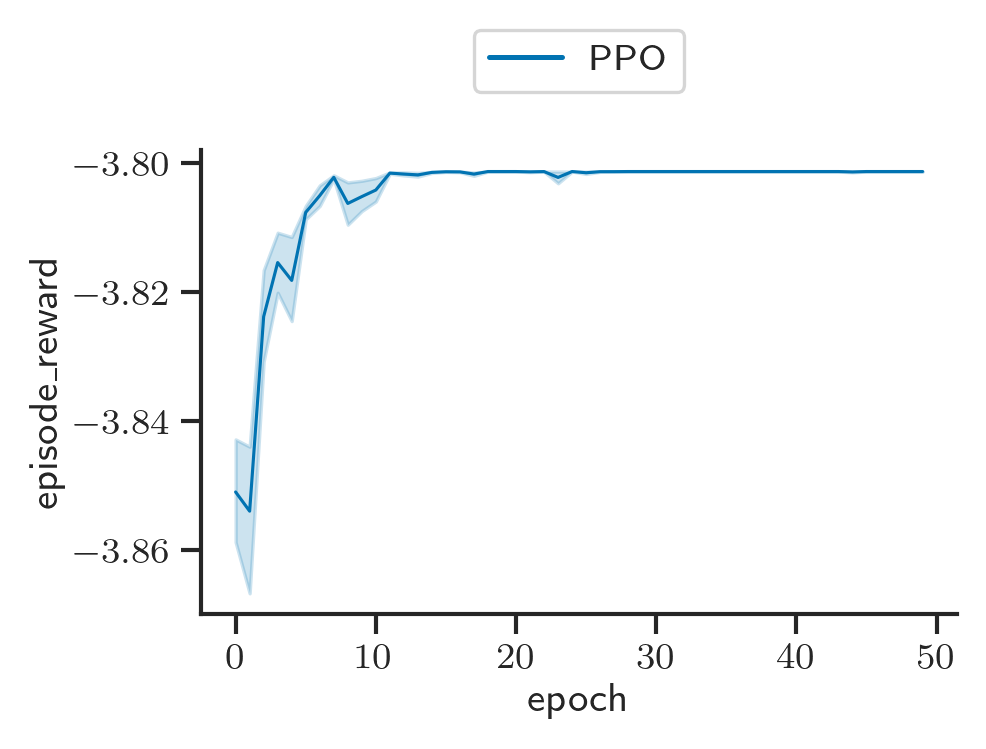

Plotting metric episode_lengths


<Figure size 1920x1440 with 0 Axes>

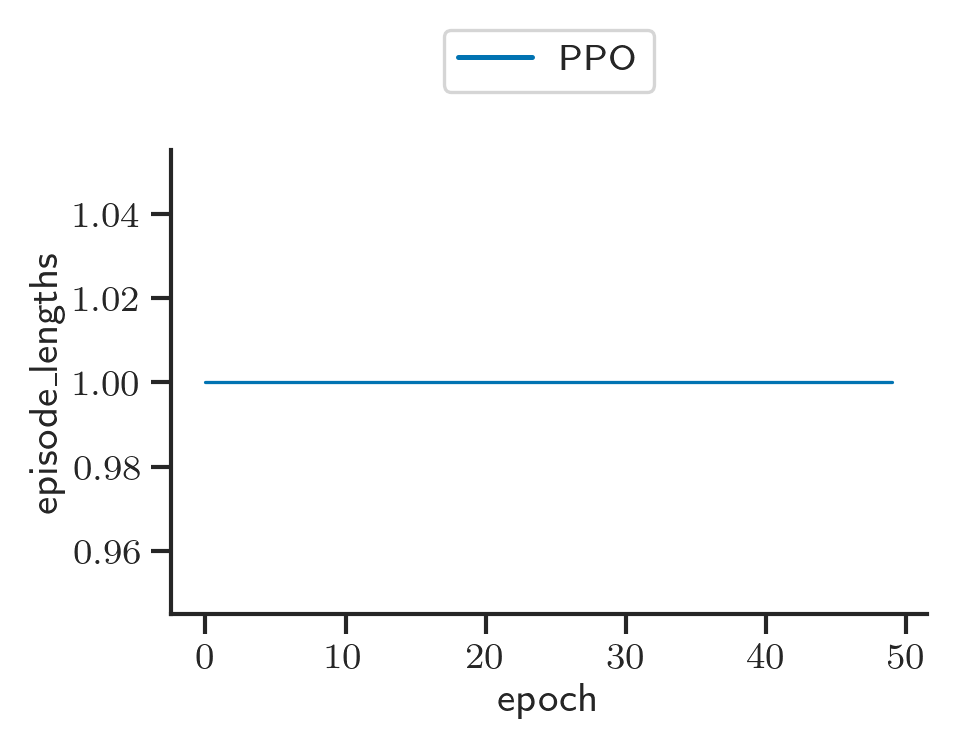

In [23]:
x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
#     plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()